In [13]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Exploration

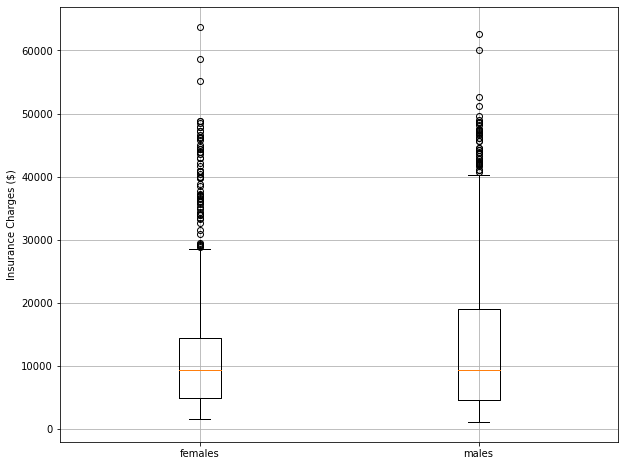

In [2]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
females = insurance[insurance['sex'] == 'female']
males = insurance[insurance['sex'] == 'male']

## Creating side-by-side box plots
plt.boxplot([females['charges'], males['charges']], labels = ['females', 'males'])
plt.ylabel('Insurance Charges ($)')
plt.grid()

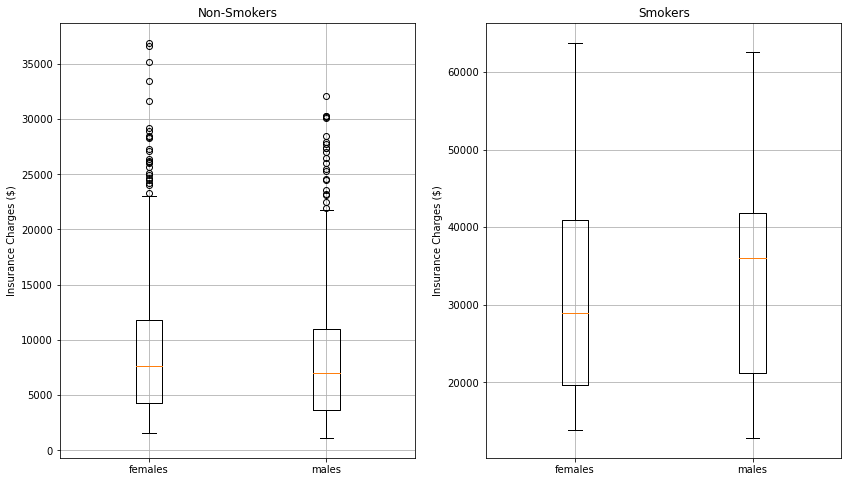

In [3]:
## Creating a new figure
fig, axes = plt.subplots(1, 2, figsize = (14, 8))

## Subsetting the data
nonsmokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'no')]
nonsmokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'no')]

smokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'yes')]
smokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'yes')]

axes[0].boxplot([nonsmokers_females['charges'], nonsmokers_males['charges']], labels = ['females', 'males'])
axes[0].set_ylabel('Insurance Charges ($)')
axes[0].set_title('Non-Smokers')
axes[0].grid()

## Plotting the second histogram
axes[1].boxplot([smokers_females['charges'], smokers_males['charges']], labels = ['females', 'males'])
axes[1].set_ylabel('Insurance Charges ($)')
axes[1].set_title('Smokers')
axes[1].grid()

In [14]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(697.5, 713.475, 'smoker <= 0.5\nmse = 150050182.675\nsamples = 1070\nvalue = 13542.264'),
 Text(348.75, 509.625, 'age <= 44.5\nmse = 36548654.211\nsamples = 839\nvalue = 8480.285'),
 Text(174.375, 305.775, 'age <= 26.5\nmse = 22405228.01\nsamples = 503\nvalue = 5663.139'),
 Text(87.1875, 101.92499999999995, 'mse = 26164091.115\nsamples = 212\nvalue = 4082.984'),
 Text(261.5625, 101.92499999999995, 'mse = 16522558.21\nsamples = 291\nvalue = 6814.318'),
 Text(523.125, 305.775, 'age <= 58.5\nmse = 28054940.288\nsamples = 336\nvalue = 12697.62'),
 Text(435.9375, 101.92499999999995, 'mse = 22891655.008\nsamples = 249\nvalue = 11643.941'),
 Text(610.3125, 101.92499999999995, 'mse = 30560579.927\nsamples = 87\nvalue = 15713.322'),
 Text(1046.25, 509.625, 'bmi <= 29.972\nmse = 131207250.365\nsamples = 231\nvalue = 31927.544'),
 Text(871.875, 305.775, 'age <= 41.0\nmse = 24154218.19\nsamples = 111\nvalue = 21405.775'),
 Text(784.6875, 101.92499999999995, 'mse = 13792122.847\nsamples = 62\

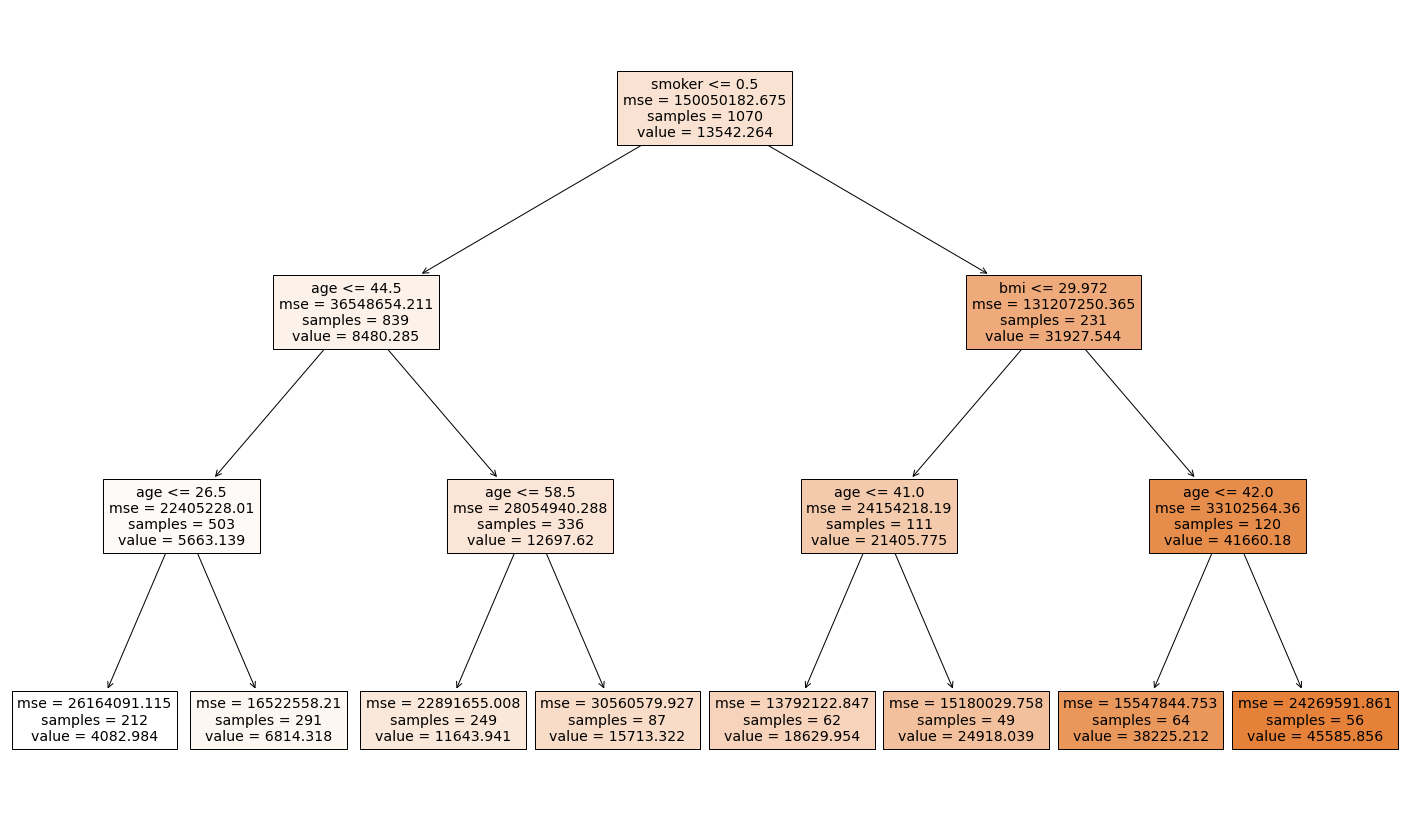

In [15]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

## saving the plot
# plt.savefig('chapter4_plot3.pdf')

In [16]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features from decision-tree
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_4'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_4'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

## Recursive Feature Elimination (RFE)

In [18]:
## Running RFE with Random forest model
RF_rfe = RFE(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), n_features_to_select = 5).fit(X_train, Y_train)

## Extracting rankings
print(RF_rfe.ranking_)

## Extracting actual feature names
a = X_train.columns[RF_rfe.support_]
print(X_train.columns[RF_rfe.support_])

[1 8 1 1 1 7 6 5 3 4 1 2]
Index(['age', 'bmi', 'children', 'smoker', 'interaction_3'], dtype='object')


In [22]:
X_train[a]

,age,bmi,children,smoker,interaction_3
897,19,25.555,1,0,0
804,23,26.510,0,0,0
799,33,24.795,0,1,0
1194,31,21.755,0,0,0
1082,38,19.950,1,0,0
...,...,...,...,...,...
1150,18,30.305,0,0,0
921,62,33.200,0,0,0
43,37,30.800,2,0,0
971,34,23.560,0,0,0


## RFE Hyper-Parameters

In [ ]:
cross_val_score(model, X, Y, cv = 5)
kf = KFold(n_splits=2)

In [17]:
X_train.shape

(1070, 12)

In [26]:
def RF_cross_val(X, Y, numb_folds, numb_features):
    
    ## Defining list to store results 
    results = list()
    
    ## Defining the number of folds
    kf = KFold(n_splits = numb_folds, shuffle = True)
    
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
    
        ## Running RFE with i features
        RF_rfe = RFE(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), n_features_to_select = numb_features).fit(X_train, Y_train)

        ## Variable to be considered
        to_select = X_train.columns[RF_rfe.support_]
        
        ## Building the Random Forest model 
        X_train_md = X_train[to_select]
        X_test_md = X_test[to_select]
        RF_md = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(X_train_md, Y_train)
        
        ## Predicting on the test data-frame and storing RMSE
        results.append(mean_squared_error(Y_test, RF_md.predict(X_test_md)))
        
    return results

In [27]:
test = RF_cross_val(X_train, Y_train, numb_folds = 5, numb_features = 2)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([   2,   18,   19,   32,   34,\n            ...\n            1043, 1052, 1055, 1062, 1067],\n           dtype='int64', length=176). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"